# Capstone Project: Police Call Outcome Prediction: Year 2016

This notebook explores and analyzes police call data in the city of San Jose, California, with the goal of predicting whether the outcome will be an arrest, a citation, or neither. The dataset contains various features such as call type, location, and final disposition. Models like Logistic Regression, Random Forest, and others are evaluated for this task.

## Data Loading and Initial Exploration

In this section, we load the police call dataset for analysis and perform some initial data exploration.

In [3]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # Ignore future warnings

import importlib

import model_utils
importlib.reload(model_utils)

import collections
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import folium
import numpy as np
from folium.plugins import HeatMap
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
import joblib
import keras_tuner as kt
from tensorflow import keras

import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import time

### Data Loading

Here, we load the police call data for the year 2016 from a CSV file.

#### Data Source
* San Jose Police Calls For Service: https://data.sanjoseca.gov/dataset/police-calls-for-service.

In [5]:
years = [2016]
year = "2016"

all_police_df = model_utils.load_data(years)

print(f'length of dataframe = {len(all_police_df)}')

length of dataframe = 309252


### Initial Data Exploration

We explore a sample of the data and generate summary statistics to get an idea of its structure and contents.

In [7]:
all_police_df.sample(5)

,CDTS,EID,START_DATE,CALL_NUMBER,PRIORITY,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,LATITUDE,LONGITUDE,neighborhood
167208,20160716000012PD,6317056,5/14/2021 12:00:00 AM,P161971039,3,7/15/2016 12:00:00 AM,7/15/2016 12:00:00 AM,23:58:22,1033A,"ALARM, AUDIBLE",NR,No Response,[600]-[700] FALCON PL,San Jose,CA,37.307468,-121.886207,Tamien
120443,20160525125642PD,6249511,5/14/2021 12:00:00 AM,P161460360,3,5/25/2016 12:00:00 AM,5/25/2016 12:00:00 AM,11:27:45,484,THEFT,R,Report taken,[1400]-[1500] VINCI PARK WY,San Jose,CA,37.378918,-121.875999,Vinci Park
160005,20160707185125PD,6306769,5/14/2021 12:00:00 AM,P161890777,6,7/7/2016 12:00:00 AM,7/7/2016 12:00:00 AM,18:43:45,1195,VEHICLE STOP,N,No report required; dispatch r,SILVER CREEK VALLEY RD & COYOT,San Jose,CA,37.295956,-121.785046,Silver Creek Country Club
30904,20160208131314PS,6114405,5/14/2021 12:00:00 AM,P160390463,2,2/8/2016 12:00:00 AM,2/8/2016 12:00:00 AM,12:19:13,1181,"VEHICLE ACCIDENT, MINOR INJURI",R,Report taken,HILLSDALE AV & NARVAEZ AV,San Jose,CA,37.266833,-121.882090,Valley View Reed
59713,20160316011616PD,6158606,5/14/2021 12:00:00 AM,P160760011,2,3/16/2016 12:00:00 AM,3/16/2016 12:00:00 AM,00:13:09,415,DISTURBANCE,N,No report required; dispatch r,[700]-[800] S 8TH ST,San Jose,CA,37.324680,-121.871970,Virginia and Martha


In [8]:
all_police_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309252 entries, 0 to 309251
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CDTS              309252 non-null  object 
 1   EID               309252 non-null  int64  
 2   START_DATE        309252 non-null  object 
 3   CALL_NUMBER       309252 non-null  object 
 4   PRIORITY          309252 non-null  int64  
 5   REPORT_DATE       309252 non-null  object 
 6   OFFENSE_DATE      309252 non-null  object 
 7   OFFENSE_TIME      309252 non-null  object 
 8   CALLTYPE_CODE     309252 non-null  object 
 9   CALL_TYPE         309246 non-null  object 
 10  FINAL_DISPO_CODE  309252 non-null  object 
 11  FINAL_DISPO       309252 non-null  object 
 12  ADDRESS           299321 non-null  object 
 13  CITY              309252 non-null  object 
 14  STATE             309252 non-null  object 
 15  LATITUDE          277974 non-null  float64
 16  LONGITUDE         27

In [9]:
all_police_df.describe()

,EID,PRIORITY,LATITUDE,LONGITUDE
count,3.092520e+05,309252.000000,277974.000000,277974.000000
mean,6.298193e+06,3.163708,37.320170,-121.870765
std,1.314468e+05,1.297511,0.043106,0.048022
min,6.067933e+06,0.000000,37.154139,-122.035696
25%,6.185278e+06,2.000000,37.295425,-121.901737
50%,6.299466e+06,3.000000,37.323818,-121.868322
75%,6.411504e+06,4.000000,37.348762,-121.837675
max,6.526535e+06,6.000000,37.534539,-121.684849


In [10]:
all_police_df.describe(include='object')

,CDTS,START_DATE,CALL_NUMBER,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,neighborhood
count,309252,309252,309252,309252,309252,309252,309252,309246,309252,309252,299321,309252,309252,276670
unique,306624,1,299241,366,366,80859,215,210,23,18,31109,1,1,295
top,20160714133432PD,5/14/2021 12:00:00 AM,P162550235,7/3/2016 12:00:00 AM,7/3/2016 12:00:00 AM,19:28:15,415,DISTURBANCE,N,No report required; dispatch r,Not a valid geographical locat,San Jose,CA,Spartan Keyes and Wool Creek
freq,3,309252,8,1289,1289,17,30954,30954,126424,126424,1358,309252,309252,8144


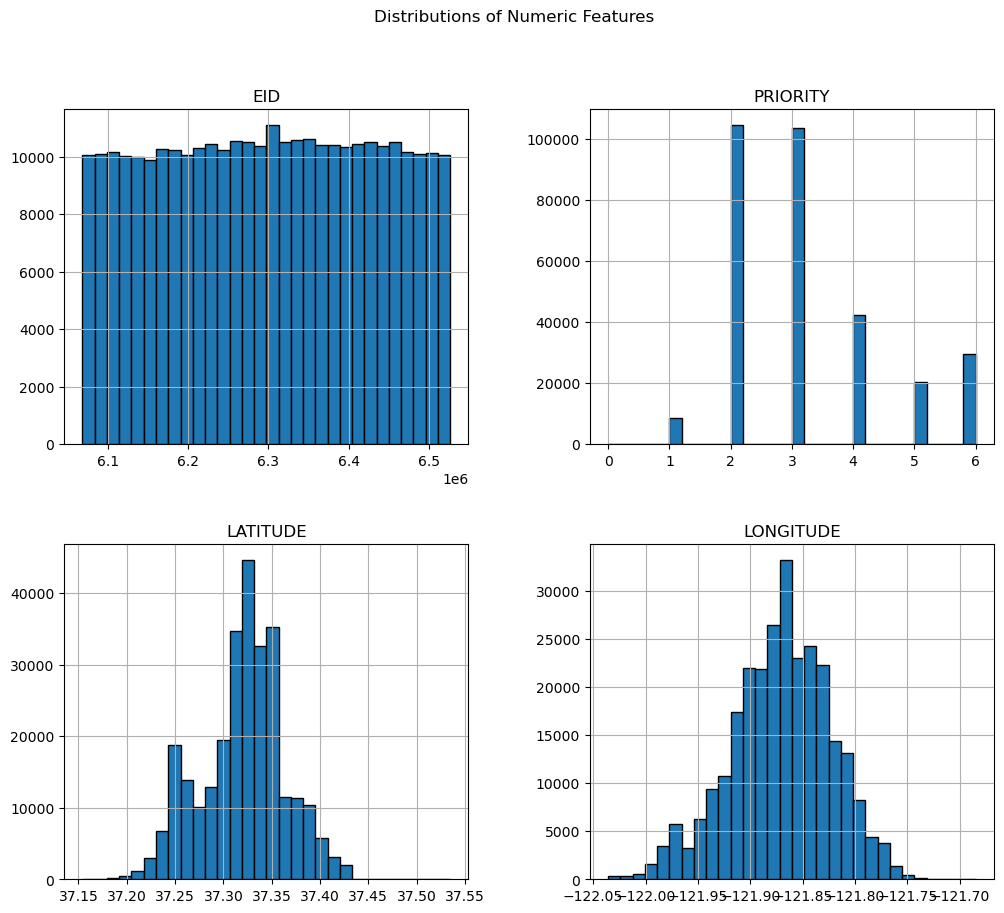

In [11]:
# Plot histograms for numeric columns
all_police_df.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle('Distributions of Numeric Features')
plt.show()

In [12]:
missing_data = all_police_df.isnull().sum()
missing_data

CDTS                    0
EID                     0
START_DATE              0
CALL_NUMBER             0
PRIORITY                0
REPORT_DATE             0
OFFENSE_DATE            0
OFFENSE_TIME            0
CALLTYPE_CODE           0
CALL_TYPE               6
FINAL_DISPO_CODE        0
FINAL_DISPO             0
ADDRESS              9931
CITY                    0
STATE                   0
LATITUDE            31278
LONGITUDE           31278
neighborhood        32582
dtype: int64

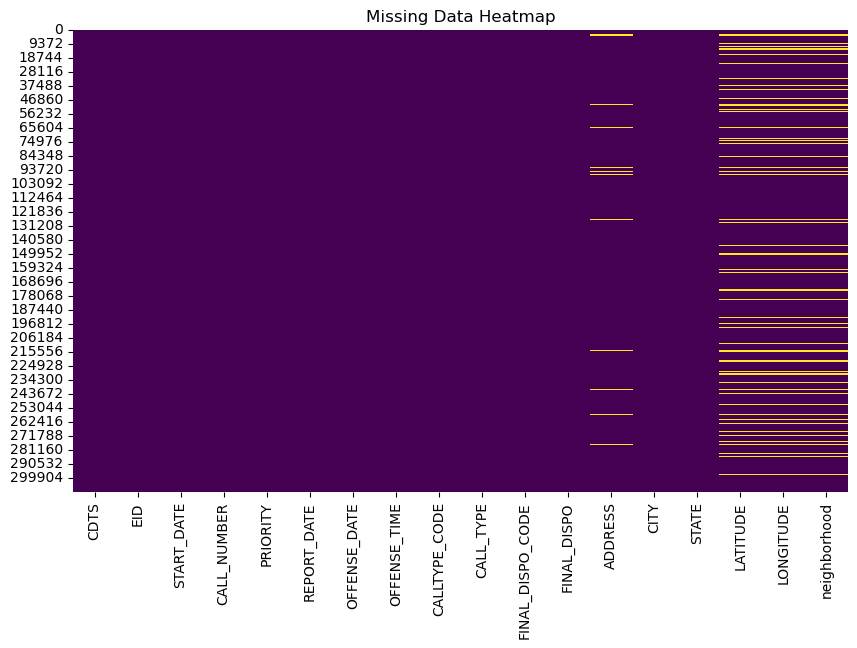

In [13]:
# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(all_police_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [14]:
for column in all_police_df.select_dtypes(include=['object']).columns:
    unique_values = all_police_df[column].nunique()
    print(f'{column}: {unique_values} unique values')

CDTS: 306624 unique values
START_DATE: 1 unique values
CALL_NUMBER: 299241 unique values
REPORT_DATE: 366 unique values
OFFENSE_DATE: 366 unique values
OFFENSE_TIME: 80859 unique values
CALLTYPE_CODE: 215 unique values
CALL_TYPE: 210 unique values
FINAL_DISPO_CODE: 23 unique values
FINAL_DISPO: 18 unique values
ADDRESS: 31109 unique values
CITY: 1 unique values
STATE: 1 unique values
neighborhood: 295 unique values


In [15]:
all_police_df['neighborhood'].value_counts()

neighborhood
Spartan Keyes and Wool Creek      8144
Little Saigon and Spring Brook    5231
Trimble Business Area             4572
O'Connor Park                     4541
Five Wounds-San Jose High         4406
                                  ... 
Meadowlands                         41
Alta Vista                          32
Villages                            30
Santa Teresa Hills                  29
Linda Vista and Hillcrest           27
Name: count, Length: 295, dtype: int64

In [17]:
all_police_df['FINAL_DISPO_CODE'].value_counts()

FINAL_DISPO_CODE
N          126424
CAN         52645
R           35370
NR          21483
G           19964
E            7975
A            6598
GD           6477
DUPNCAN      5998
H            4648
O            3744
C            3476
T            3384
B            3158
ADV          2665
D            2607
U            1787
F             638
M             135
P              65
TOT             8
Z               2
AA              1
Name: count, dtype: int64

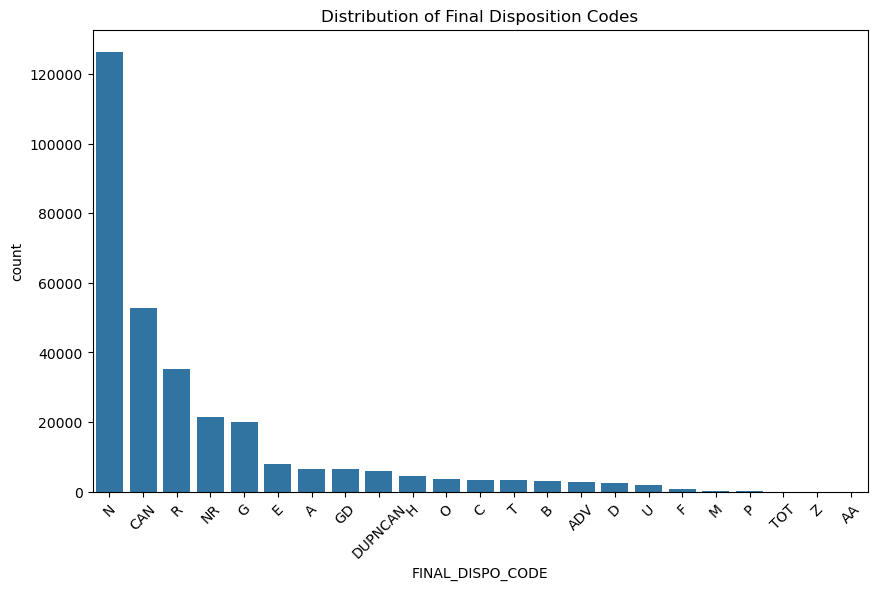

In [18]:
# Bar plot for target variable (FINAL_DISPO_CODE)
plt.figure(figsize=(10, 6))
sns.countplot(data=all_police_df, x='FINAL_DISPO_CODE', order=all_police_df['FINAL_DISPO_CODE'].value_counts().index)
plt.title('Distribution of Final Disposition Codes')
plt.xticks(rotation=45)
plt.show()

In [19]:
all_police_df['FINAL_DISPO'].value_counts()

FINAL_DISPO
No report required; dispatch r    126424
Canceled                           52645
Report taken                       35370
No Response                        21483
Gone on Arrival/unable to loca     19964
No Disposition                     15151
Traffic Citation Issued, Non-H      7975
Arrest Made                         6598
Courtesy Service/Citizen or ag      4648
Supplemental report taken           3744
Criminal Citation                   3476
Turned over To (TOT)                3384
Arrest by Warrant                   3158
Traffic Citation Issued, Hazar      2607
Unfounded event                     1787
Field Interview (F.I.) Complet       638
Stranded motorist assist             135
Prior case, follow-up activity        65
Name: count, dtype: int64

In [24]:
# Create a mapping between FINAL_DISPO_CODE and FINAL_DISPO
final_dispo_mapping = dict(zip(all_police_df['FINAL_DISPO_CODE'], all_police_df['FINAL_DISPO']))
final_dispo_mapping

{'N': 'No report required; dispatch r',
 'NR': 'No Response',
 'R': 'Report taken',
 'CAN': 'Canceled',
 'T': 'Turned over To (TOT)',
 'G': 'Gone on Arrival/unable to loca',
 'E': 'Traffic Citation Issued, Non-H',
 'DUPNCAN': 'No Disposition',
 'O': 'Supplemental report taken',
 'A': 'Arrest Made',
 'B': 'Arrest by Warrant',
 'GD': 'No Disposition',
 'H': 'Courtesy Service/Citizen or ag',
 'D': 'Traffic Citation Issued, Hazar',
 'U': 'Unfounded event',
 'C': 'Criminal Citation',
 'P': 'Prior case, follow-up activity',
 'ADV': 'No Disposition',
 'F': 'Field Interview (F.I.) Complet',
 'M': 'Stranded motorist assist',
 'TOT': 'No Disposition',
 'AA': 'No Disposition',
 'Z': 'No Disposition'}

In [25]:
call_type_code_mapping = dict(zip(all_police_df['CALLTYPE_CODE'], all_police_df['CALL_TYPE']))
call_type_code_mapping

{'SUSCIR': 'SUSPICIOUS CIRCUMSTANCES',
 '415M': 'DISTURBANCE, MUSIC',
 '1033A': 'ALARM, AUDIBLE',
 '1181': 'VEHICLE ACCIDENT, MINOR INJURI',
 '22500': 'PARKING VIOLATION',
 '647': 'VAGRANT',
 '415F': 'DISTURBANCE, FAMILY',
 'WELCKEMS': 'WELFARE CHECK (COMBINED EVENT)',
 '1095': 'PEDESTRIAN STOP',
 '242': 'BATTERY',
 '23103': 'RECKLESS DRIVING',
 '1066': 'SUSPICIOUS PERSON',
 '6M': 'MISDEMEANOR WANT',
 'WELCK': 'WELFARE CHECK',
 '1154': 'SUSPICIOUS VEHICLE',
 '1195': 'VEHICLE STOP',
 '1062': 'MEET THE CITIZEN',
 '415AEMS': 'DISTURBANCE, FIGHT (COMBINED E',
 '415': 'DISTURBANCE',
 '911CELL': 'UNK TYPE 911 CALL FROM CELL',
 '1057': 'FIREARMS DISCHARGED',
 '273.5EMS': 'DOMESTIC VIOLENCE  (COMBINED E',
 '415UNK': 'DISTURBANCE, UNKNOWN',
 '1033S': 'ALARM, SILENT',
 'SUSCIREMS': 'SUSPICIOUS CIRCUMSTANCES (COMB',
 '459R': 'BURGLARY  REPORT  (460)',
 '459': 'BURGLARY (460)',
 '415N': 'DISTURBANCE, NEIGHBOR',
 '5150': 'MENTALLY DISTURBED PERSON',
 '415W': 'DISTURBANCE, WEAPON',
 '1065JX': 'MISSI

## Focus on Target Dispositions

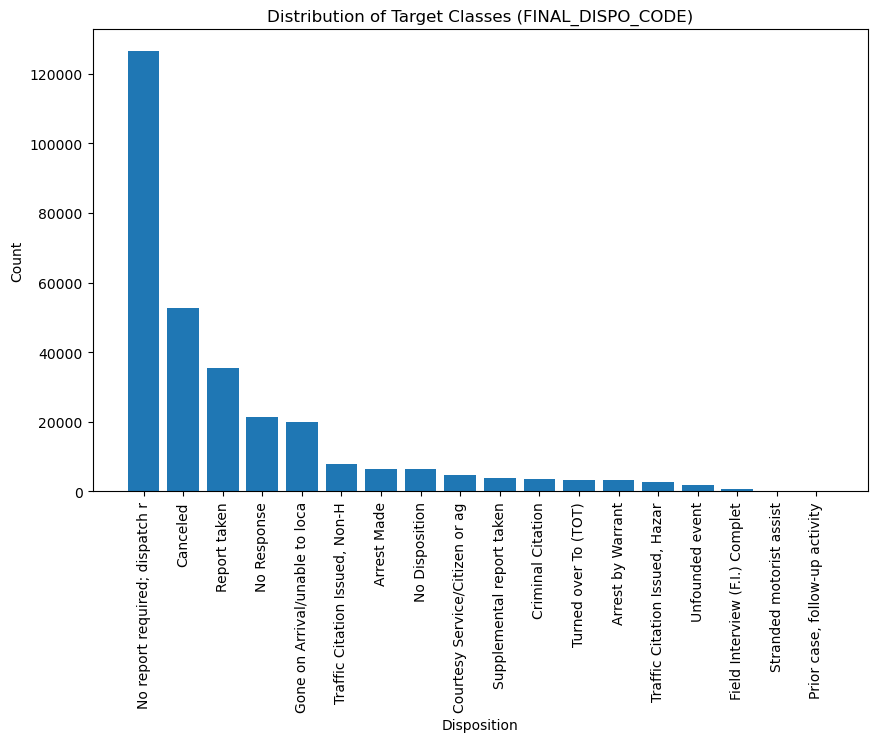

In [29]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['FINAL_DISPO_CODE'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [final_dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (FINAL_DISPO_CODE)')
plt.xlabel('Disposition')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()

In [31]:
model_utils.transform_offense_date(all_police_df)

In [32]:
dispo_mapping = model_utils.calc_dispo_subset(all_police_df)
all_police_df['DISPO_SUBSET'].value_counts()

DISPO_SUBSET
Other    296020
A          6598
C          3476
B          3158
Name: count, dtype: int64

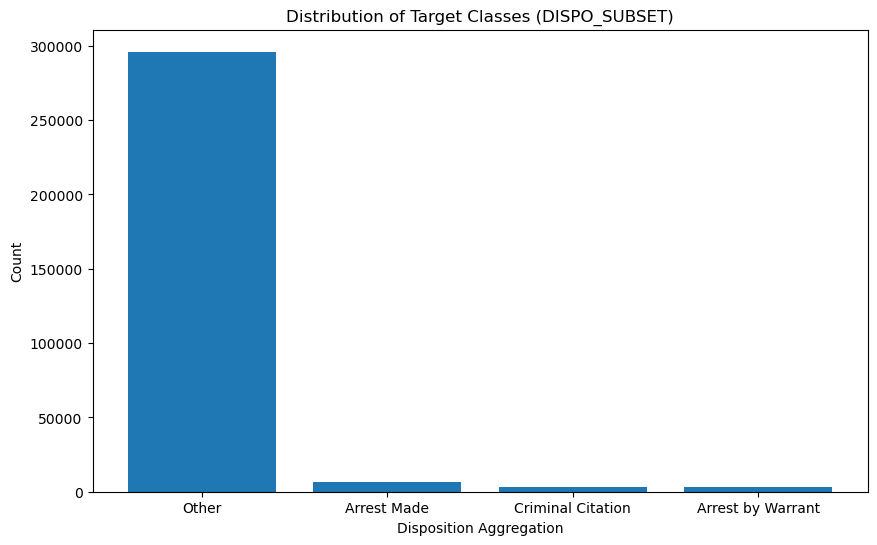

In [33]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['DISPO_SUBSET'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (DISPO_SUBSET)')
plt.xlabel('Disposition Aggregation')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.savefig('images/class_imbalance.png')
plt.show()

## Data Cleaning and Feature Engineering

In [35]:
police_calls_encoded = model_utils.clean_and_transform_data(all_police_df)

Police Calls Dataset: 309252 rows before cleaning, 276664 rows after cleaning.


In [36]:
police_calls_encoded.shape

(276664, 15)

In [37]:
police_calls_encoded

,PRIORITY,CALLTYPE_CODE,LATITUDE,LONGITUDE,neighborhood,OFFENSE_HOUR,OFFENSE_DAY_OF_WEEK,OFFENSE_MONTH,OFFENSE_YEAR,AFTER_COVID,DISPO_SUBSET,DISTANCE_FROM_CENTER,LATITUDE^2,LATITUDE LONGITUDE,LONGITUDE^2
0,3,SUSCIR,0.114173,1.154305,Meadow Fair,0,5,5,2016,No,Other,0.072274,0.013035,0.131790,1.332419
1,4,415M,-0.160428,-1.761524,Winchester Lynnhaven,0,5,5,2016,No,Other,0.072748,0.025737,0.282597,3.102967
2,3,1033A,-0.819541,1.672707,Silver Creek Country Club,0,5,5,2016,No,Other,0.109691,0.671647,-1.370852,2.797948
4,2,1181,0.077570,-0.631069,Delmas Park,0,5,5,2016,No,Other,0.020476,0.006017,-0.048952,0.398248
5,4,22500,0.011342,-0.273233,Guadalupe Washington,0,5,5,2016,No,Other,0.017740,0.000129,-0.003099,0.074656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309246,4,415FC,1.421276,-0.041170,Vinci Park,0,5,12,2016,No,Other,0.045399,2.020026,-0.058514,0.001695
309247,3,11377,-0.296242,-1.270220,Fruitdale and Sherman Oaks,0,5,12,2016,No,C,0.054392,0.087759,0.376293,1.613460
309248,3,415F,0.006418,-0.937611,Fruitdale,0,5,12,2016,No,Other,0.033948,0.000041,-0.006018,0.879114
309249,3,1182,0.557458,1.266242,Ocala,0,5,12,2016,No,Other,0.076668,0.310760,0.705877,1.603369


## Define X and Y

In [40]:
# load the encoder file
encoder = joblib.load('one_hot_encoder.pkl')

In [43]:
X_train, X_test, y_train, y_test, label_names, class_labels, X_train_resampled, y_train_resampled, _ = \
    model_utils.split_data(police_calls_encoded, dispo_mapping, encoder)

classes = ['A' 'B' 'C' 'Other']
(221331, 14)
(55333, 14)
['Arrest Made', 'Arrest by Warrant', 'Criminal Citation', 'Other']
Counter({3: 211860, 0: 4792, 2: 2419, 1: 2260})
Counter({3: 9471, 0: 4792, 2: 2419, 1: 2260})


In [45]:
X_train.shape

(221331, 529)

In [50]:
X_train

,PRIORITY,LATITUDE,LONGITUDE,DISTANCE_FROM_CENTER,LATITUDE^2,LATITUDE LONGITUDE,LONGITUDE^2,CALLTYPE_CODE_1033,CALLTYPE_CODE_1033A,CALLTYPE_CODE_1033CTX,...,neighborhood_Willow Glen South,neighborhood_Willow Glen West,neighborhood_Willow Vale,neighborhood_Willowmont,neighborhood_Winchester,neighborhood_Winchester Lynnhaven,neighborhood_Windmill Springs,neighborhood_Wooster and East Ct and West Ct,neighborhood_YB Lucretia,AFTER_COVID_Yes
129016,0.649902,0.265141,0.386902,-0.710449,-0.686524,0.238224,-0.587894,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56012,-0.896528,1.768698,-0.389088,-0.033887,1.575315,-0.504508,-0.586599,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29319,2.196332,1.281681,-1.224021,-0.082031,0.476883,-1.331385,0.344627,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88559,-0.896528,0.285874,-0.184689,-1.465263,-0.678050,0.091895,-0.667709,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77559,2.196332,0.195602,-0.990429,-0.771694,-0.710306,-0.041100,-0.013014,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168816,-0.896528,1.905053,0.046951,0.208069,1.945659,0.225386,-0.689802,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209451,-0.896528,-0.129068,-0.165858,-1.006145,-0.726774,0.161568,-0.672275,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198429,-0.123313,1.683458,-0.696356,-0.063567,1.357757,-0.958937,-0.355980,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
246190,-0.896528,0.593992,-0.443810,-1.457432,-0.477257,-0.106164,-0.555082,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


y_train distribution: Counter({3: 211860, 0: 4792, 2: 2419, 1: 2260})
y_test distribution: Counter({3: 52965, 0: 1198, 2: 605, 1: 565})
y_train_resampled distribution: Counter({3: 211860, 0: 4792, 2: 2419, 1: 2260})


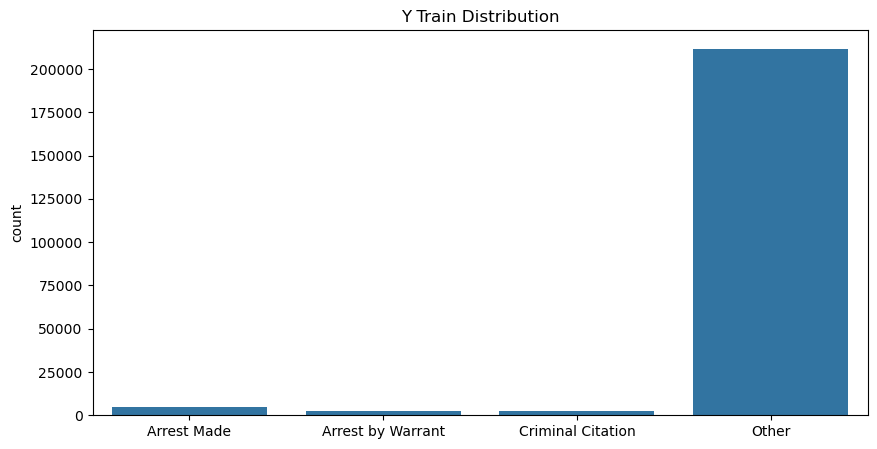

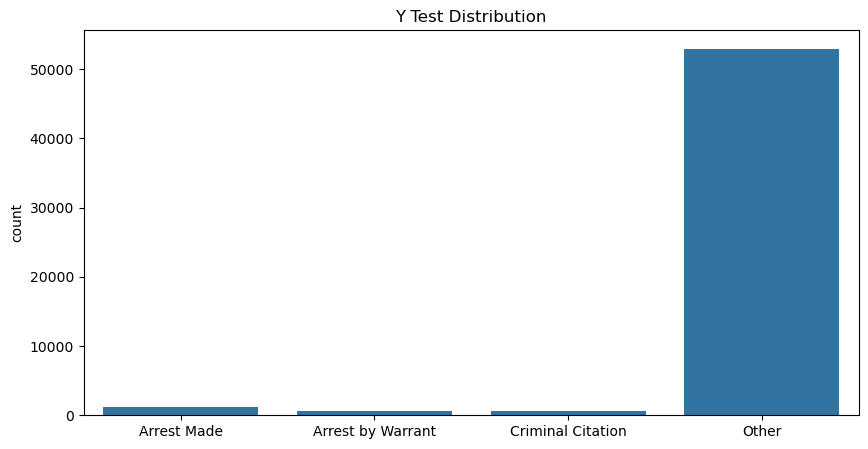

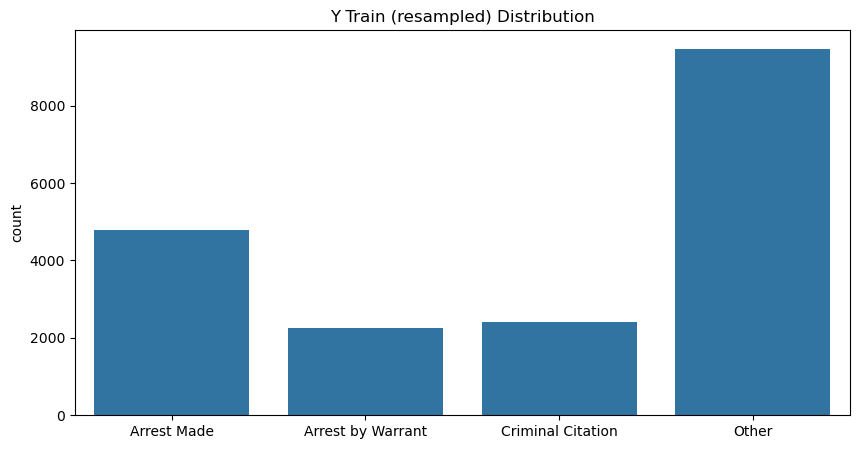

In [54]:
# Count the occurrences of each class in y_train and y_test
train_counts = collections.Counter(y_train)
test_counts = collections.Counter(y_test)

print("y_train distribution:", train_counts)
print("y_test distribution:", test_counts)

train_resampled_counts = collections.Counter(y_train_resampled)

print("y_train_resampled distribution:", train_counts)

# Bar plot for y_train
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train Distribution')
plt.show()

# Bar plot for y_test
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_test)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Test Distribution')
plt.show()

# Bar plot for y_train_resampled
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train_resampled)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train (resampled) Distribution')
plt.show()

## Evaluate Different Baseline Models

### Most Frequent Class Model

In [62]:
# Step 1: Find the most frequent class in the training set
most_frequent_class = np.bincount(y_train).argmax()

In [63]:
# Step 2: Predict the most frequent class for all samples in the test set
y_pred_baseline = [most_frequent_class] * len(y_test)

In [66]:
# Step 3: Evaluate the baseline model
print("Baseline Model (Most Frequent Class) Classification Report:")
print(classification_report(y_test, y_pred_baseline, zero_division=0, target_names=label_names))

Baseline Model (Most Frequent Class) Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.00      0.00      0.00      1198
Arrest by Warrant       0.00      0.00      0.00       565
Criminal Citation       0.00      0.00      0.00       605
            Other       0.96      1.00      0.98     52965

         accuracy                           0.96     55333
        macro avg       0.24      0.25      0.24     55333
     weighted avg       0.92      0.96      0.94     55333



### Logistic Regression

In [69]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000, random_state=42)

In [71]:
y_pred_lr = lr_model.predict(X_test)
print("DONE")

DONE


In [75]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, zero_division=0, target_names=label_names))

Logistic Regression Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.22      0.70      0.33      1198
Arrest by Warrant       0.57      0.69      0.62       565
Criminal Citation       0.13      0.50      0.21       605
            Other       0.99      0.91      0.95     52965

         accuracy                           0.89     55333
        macro avg       0.48      0.70      0.53     55333
     weighted avg       0.96      0.89      0.92     55333



#### Hyperparameter Tuning

In [77]:
grid_search_scoring_method = 'f1_macro'

In [78]:
# Define parameter grid
param_grid_lr = {
    'C': [0.1, 1, 10]
}

grid_lr = GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=42), param_grid=param_grid_lr, 
                              cv=5, n_jobs=2, verbose=1, scoring=grid_search_scoring_method)

grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=2, param_grid={'C': [0.1, 1, 10]}, scoring='f1_macro',
             verbose=1)

In [79]:
# Best parameters and score
print(f"Best Parameters: {grid_lr.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_lr.best_score_:.4f}")

Best Parameters: {'C': 10}
Best Score (f1_macro): 0.6018


In [80]:
# Use the best estimator to make predictions
best_lr = grid_lr.best_estimator_

# save
joblib.dump(best_lr, f"models/{year}/best_logistic_regression.pkl") 

['models/2016/best_logistic_regression.pkl']

In [81]:
# load
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")

In [82]:
y_pred_best_lr = best_lr.predict(X_test)

# Evaluate the best model
print("Best Logistic Regression Classification Report for Police Calls:")
print(classification_report(y_test, y_pred_best_lr, zero_division=0, target_names=label_names))

Best Logistic Regression Classification Report for Police Calls:
                   precision    recall  f1-score   support

      Arrest Made       0.61      0.39      0.47      1198
Arrest by Warrant       0.76      0.68      0.72       565
Criminal Citation       0.58      0.16      0.25       605
            Other       0.98      0.99      0.99     52965

         accuracy                           0.97     55333
        macro avg       0.73      0.55      0.61     55333
     weighted avg       0.96      0.97      0.96     55333



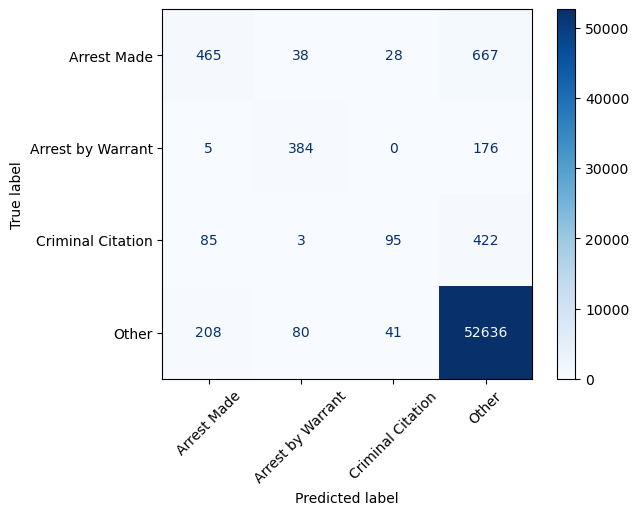

In [83]:
ConfusionMatrixDisplay.from_estimator(best_lr, X_test, y_test, display_labels=label_names, xticks_rotation=45, cmap=plt.cm.Blues)

#### Feature Importance

In [85]:
from sklearn.inspection import permutation_importance

# Calculate permutation feature importance on sample data to speed things up

# Sample 20% of X_test and y_test
sample_size = int(0.2 * len(X_test))
X_test_sample = X_test.sample(sample_size, random_state=42)

# Get the positional indices from the sample, and use them to index the numpy array y_test
pos_indices = X_test.index.get_indexer(X_test_sample.index)
y_test_sample = y_test[pos_indices]

permutation_importance_result = permutation_importance(best_lr, X_test_sample, y_test_sample, n_repeats=3, random_state=42)

In [88]:
# Create a DataFrame to store the feature importance results
importance_df = pd.DataFrame({
    'feature': X_test_sample.columns,
    'importance_mean': permutation_importance_result.importances_mean
})

# Define a mapping of one-hot encoded columns to their original categorical feature
# This is a dictionary where keys are the original feature names, and values are lists of one-hot encoded columns
one_hot_mapping = {
    'CALLTYPE_CODE': [col for col in X_test_sample.columns if col.startswith("CALLTYPE_CODE_")],
    'neighborhood': [col for col in X_test_sample.columns if col.startswith("neighborhood_")]
}

# Initialize a list to store aggregated and non-one-hot encoded features
final_importance = []

# 1. Aggregate the importance for one-hot encoded features
for original_feature, encoded_columns in one_hot_mapping.items():
    # Sum the importance of the one-hot encoded columns for this feature
    aggregated_importance = importance_df.loc[importance_df['feature'].isin(encoded_columns), 'importance_mean'].sum()
    final_importance.append({
        'feature': original_feature,
        'importance_mean': aggregated_importance
    })

# 2. Add the importance of the non-one-hot encoded features
# Find columns that are not part of the one-hot encoded mappings
all_one_hot_encoded_columns = [col for sublist in one_hot_mapping.values() for col in sublist]
non_one_hot_encoded_features = importance_df.loc[~importance_df['feature'].isin(all_one_hot_encoded_columns)]

# Append non-one-hot encoded features' importance to the final list
for _, row in non_one_hot_encoded_features.iterrows():
    final_importance.append({
        'feature': row['feature'],
        'importance_mean': row['importance_mean']
    })

# Convert final importance list to a DataFrame
final_importance_df = pd.DataFrame(final_importance)

# Sort by importance for easier interpretation
final_importance_df = final_importance_df.sort_values(by='importance_mean', ascending=False)

In [91]:
# Use display to see the dataframe nicely formatted
from IPython.display import display
display(final_importance_df)

,feature,importance_mean
0,CALLTYPE_CODE,0.029911
2,PRIORITY,0.000633
1,neighborhood,0.000422
5,DISTANCE_FROM_CENTER,0.000060
9,AFTER_COVID_Yes,0.000000
4,LONGITUDE,-0.000030
7,LATITUDE LONGITUDE,-0.000030
6,LATITUDE^2,-0.000090
8,LONGITUDE^2,-0.000181
3,LATITUDE,-0.000361


In [92]:
# Set maximum number of rows to display
pd.set_option('display.max_rows', 200)

In [93]:
feature_names = X_train.columns

call_types = []
for feature_name in feature_names:
    if feature_name.startswith("CALLTYPE_CODE_"):
        code = feature_name[14:]
        call_type = call_type_code_mapping.get(code, '')
        call_types.append(call_type)
    else:
        call_types.append("")

# Create a DataFrame of the results
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': permutation_importance_result.importances_mean,
    'Call Type': call_types
})

# Sort by importance and display the top features
top_perm_features = perm_importance_df.sort_values(by='Importance', ascending=False).head(100)
print(top_perm_features)

                                         Feature  Importance  \
200                             CALLTYPE_CODE_6M    0.008073   
199                             CALLTYPE_CODE_6F    0.004970   
184                           CALLTYPE_CODE_601T    0.003464   
64                           CALLTYPE_CODE_11377    0.001115   
84                           CALLTYPE_CODE_14601    0.000994   
8                            CALLTYPE_CODE_1033A    0.000964   
196                           CALLTYPE_CODE_647F    0.000904   
136                            CALLTYPE_CODE_415    0.000723   
107                          CALLTYPE_CODE_23152    0.000663   
0                                       PRIORITY    0.000633   
165                            CALLTYPE_CODE_484    0.000452   
102                          CALLTYPE_CODE_22500    0.000392   
67                           CALLTYPE_CODE_11550    0.000392   
86                             CALLTYPE_CODE_148    0.000392   
171                            CALLTYPE_

In [94]:
for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })
    
    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(50)
    
    # Display the top most important features
    print(f"\nlabel = {label_names[index]}")
    print(top_features[['Display Name', 'Coefficient']])


label = Arrest Made
                                  Display Name  Coefficient
184                   Call Type: TRUANT (TABS)     3.630264
107                 Call Type: MISDEMEANOR DUI     3.342063
82      Call Type: CARRYING A CONCEALED WEAPON     3.275680
102               Call Type: PARKING VIOLATION    -2.691598
108                      Call Type: FELONY DUI     2.621092
72   Call Type: VEHICLE ACCIDENT, PROPERTY DAM    -2.482574
196                 Call Type: DRUNK IN PUBLIC     2.438606
67      Call Type: USE OF CONTROLLED SUBSTANCE     2.407918
43     Call Type: STOLEN VEHICLE, GANG RELATED     2.360280
86                 Call Type: RESISTING ARREST     2.324452
87   Call Type: RESISTING ARREST, GANG RELATED     2.237132
22                 Call Type: MEET THE CITIZEN    -2.229323
80                  Call Type: ILLEGAL WEAPONS     2.173467
109              Call Type: FALSE IMPRISONMENT     2.160290
175       Call Type: MENTALLY DISTURBED PERSON     2.152519
81    Call Type: IL

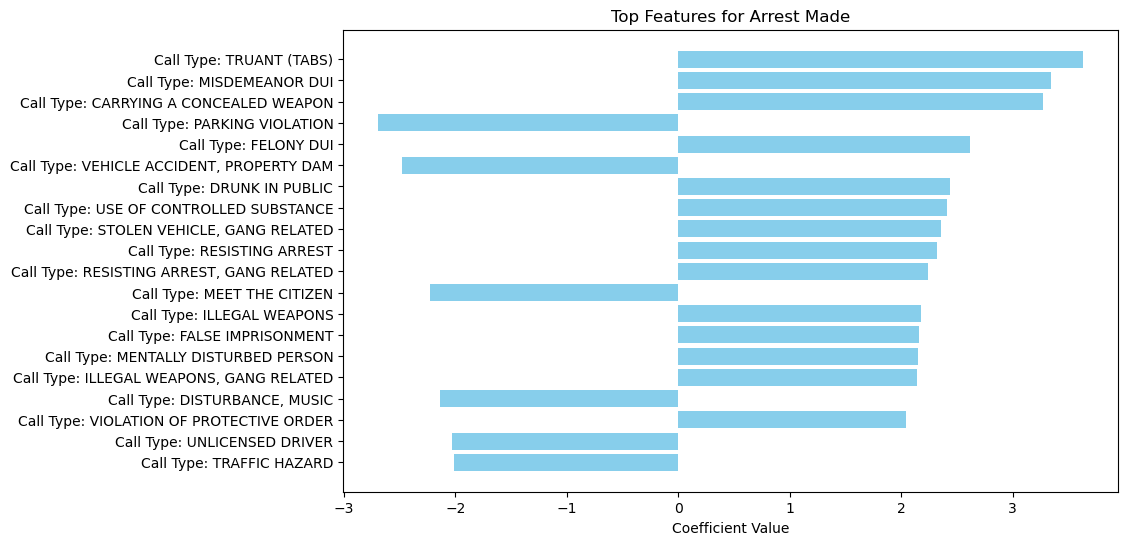

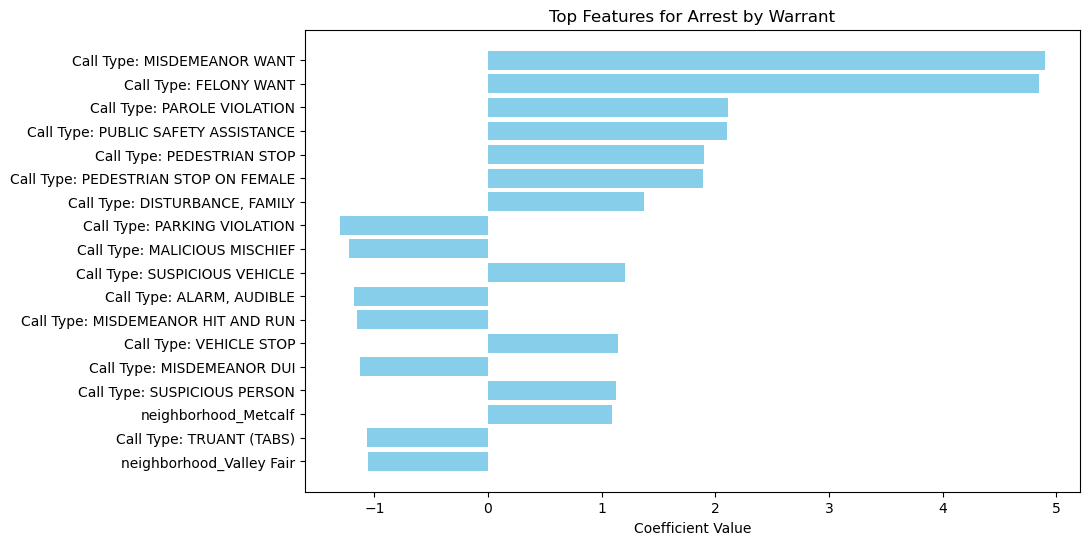

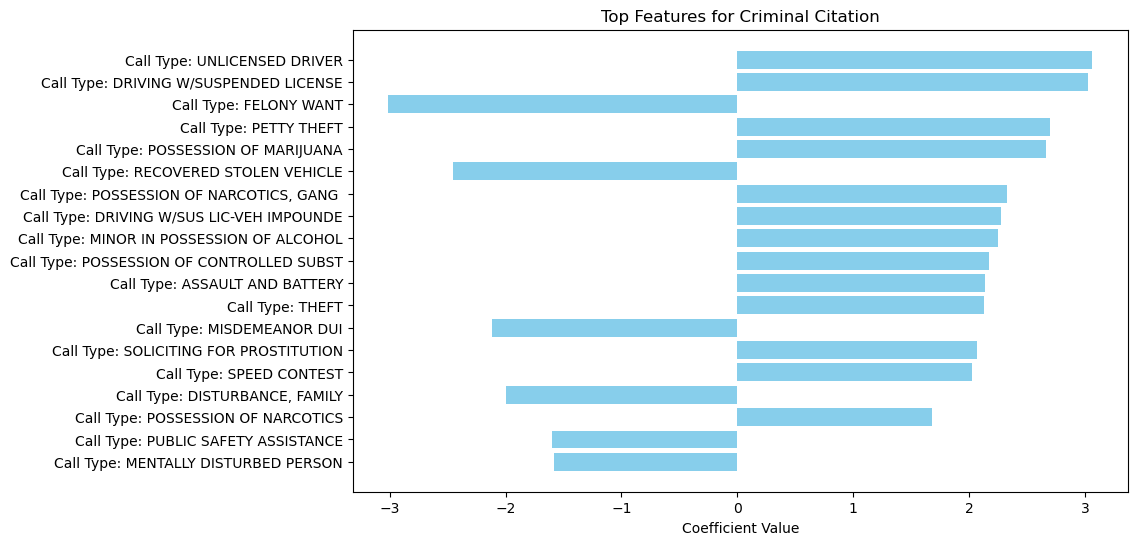

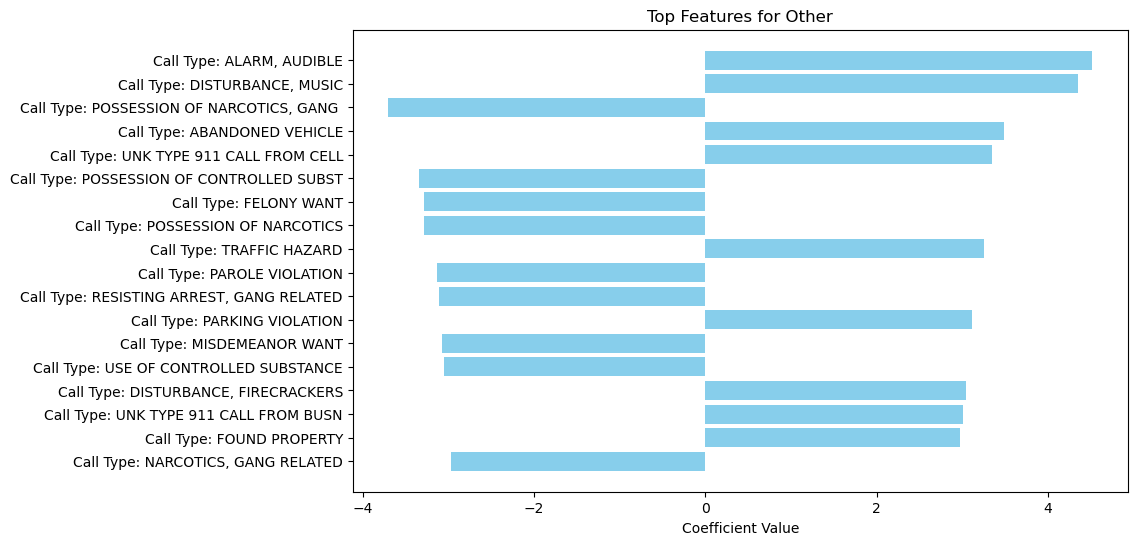

In [95]:
import matplotlib.pyplot as plt

for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })

    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(20)
    
    # Plot the top coefficients as a bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Display Name'], top_features['Coefficient'], color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title(f'Top Features for {label_names[index]}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient at the top
    plt.show()


### Random Forest

In [97]:
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs = -1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [98]:
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0, target_names=label_names))

Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.57      0.42      0.48      1198
Arrest by Warrant       0.70      0.59      0.64       565
Criminal Citation       0.43      0.20      0.27       605
            Other       0.98      0.99      0.98     52965

         accuracy                           0.97     55333
        macro avg       0.67      0.55      0.60     55333
     weighted avg       0.96      0.97      0.96     55333



#### Hyperparameter Tuning and Cross Validation

In [100]:
# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 60],
}

# Initialize Grid Search
grid_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, n_jobs=-1,
                              cv=5, verbose=1, scoring=grid_search_scoring_method)

# Fit Grid Search
grid_rf.fit(X_train, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_rf.best_score_:.2f}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'n_estimators': 50}
Best Score (f1_macro): 0.60


In [101]:
best_rf = grid_rf.best_estimator_

In [102]:
# save
joblib.dump(best_rf, f"models/{year}/best_random_forest.pkl") 

['models/2016/best_random_forest.pkl']

In [103]:
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")

In [104]:
# Use the best estimator to make predictions
y_pred_best_rf = best_rf.predict(X_test)

# Evaluate the best model
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf, zero_division=0, target_names=label_names))

Best Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.58      0.42      0.49      1198
Arrest by Warrant       0.71      0.61      0.66       565
Criminal Citation       0.44      0.21      0.29       605
            Other       0.98      0.99      0.98     52965

         accuracy                           0.97     55333
        macro avg       0.68      0.56      0.60     55333
     weighted avg       0.96      0.97      0.96     55333



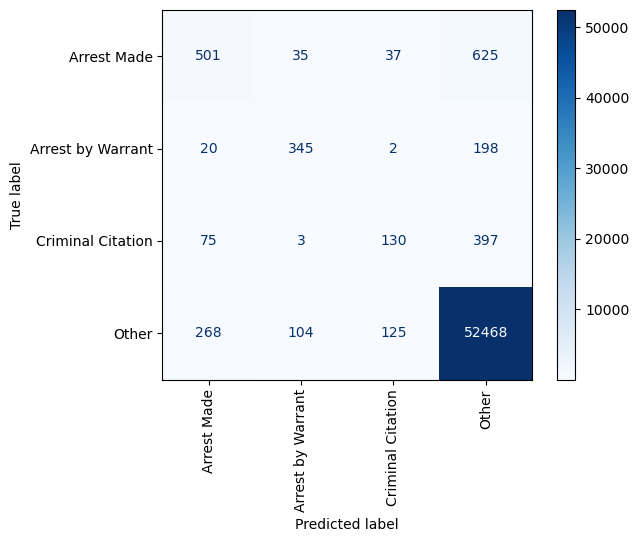

In [105]:
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)

plt.show()

In [106]:
#### Optuna

def rf_objective(trial):
    # Suggest values for the hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 100)
    max_depth = trial.suggest_int('max_depth', 5, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

    # Initialize RandomForest with suggested hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    
    # Use cross-validation to evaluate the model
    score = cross_val_score(clf, X_train_resampled, y_train_resampled, cv=5, scoring='f1_macro').mean()
    return score

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(rf_objective, n_trials=20)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-10-07 22:36:00,547] A new study created in memory with name: no-name-996b4936-d240-43b5-8210-6d1928a16cb6
[I 2024-10-07 22:36:01,605] Trial 0 finished with value: 0.6795230605138934 and parameters: {'n_estimators': 70, 'max_depth': 67, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.6795230605138934.
[I 2024-10-07 22:36:02,859] Trial 1 finished with value: 0.7123088339849978 and parameters: {'n_estimators': 61, 'max_depth': 98, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7123088339849978.
[I 2024-10-07 22:36:04,103] Trial 2 finished with value: 0.6717696602020362 and parameters: {'n_estimators': 88, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7123088339849978.
[I 2024-10-07 22:36:05,095] Trial 3 finished with value: 0.6551634297502715 and parameters: {'n_estimators': 85, 'max_depth': 55, 'min_

Best hyperparameters: {'n_estimators': 71, 'max_depth': 62, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}


In [107]:
best_params = study.best_params
best_params

{'n_estimators': 71,
 'max_depth': 62,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt'}

In [108]:
# Train the RandomForest using the best hyperparameters
best_rf_2 = RandomForestClassifier(**best_params, n_jobs=-1)
best_rf_2.fit(X_train, y_train)

RandomForestClassifier(max_depth=62, min_samples_leaf=2, n_estimators=71,
                       n_jobs=-1)

In [109]:
# Use the best estimator to make predictions
y_pred_best_rf_2 = best_rf_2.predict(X_test)

# Evaluate the best model
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf_2, zero_division=0, target_names=label_names))

Best Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.65      0.39      0.49      1198
Arrest by Warrant       0.76      0.68      0.72       565
Criminal Citation       0.69      0.12      0.21       605
            Other       0.98      0.99      0.99     52965

         accuracy                           0.97     55333
        macro avg       0.77      0.55      0.60     55333
     weighted avg       0.96      0.97      0.96     55333



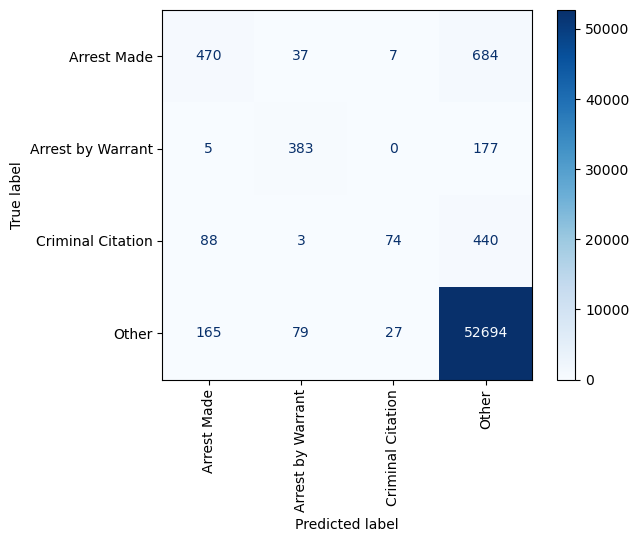

In [110]:
ConfusionMatrixDisplay.from_estimator(best_rf_2, X_test, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)
plt.show()

#### Feature Importance

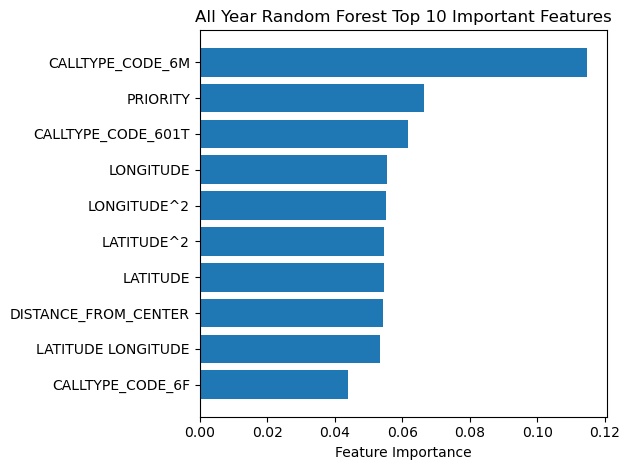

In [112]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances and sort them in descending order
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-10:]  # Select top 10 features

# Create a bar chart for the top 10 features
plt.barh(np.array(feature_names)[indices], importances[indices])
plt.xlabel('Feature Importance')
plt.title('All Year Random Forest Top 10 Important Features')
plt.tight_layout()  # Adjusts the padding automatically
plt.savefig('images/all_year_random_forest_feature_importance.png')
plt.show()

### Multilayer Perceptron Model

In [114]:
# Set up early stopping and model checkpoint callbacks so we choose the best model

# Define the callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor validation loss
    patience=3,          # stop training if val_loss doesn't improve for N epochs
    restore_best_weights=True  # restore model to the epoch with the best val_loss
)

# Save the best model
model_checkpoint = ModelCheckpoint(
    'best_model.mcp.keras',    # path to save the best model
    monitor='val_loss', # monitor validation loss
    save_best_only=True # only save the model with the best val_loss
)

In [115]:
# Build the MLP model
mlp_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(np.unique(y_train)), activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [116]:
# Train the model
history = mlp_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, 
                        callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
2767/2767 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9593 - loss: 0.1819 - val_accuracy: 0.9703 - val_loss: 0.1139
Epoch 2/20
2767/2767 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9687 - loss: 0.1160 - val_accuracy: 0.9705 - val_loss: 0.1110
Epoch 3/20
2767/2767 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9694 - loss: 0.1114 - val_accuracy: 0.9712 - val_loss: 0.1088
Epoch 4/20
2767/2767 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9694 - loss: 0.1091 - val_accuracy: 0.9707 - val_loss: 0.1089
Epoch 5/20
2767/2767 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9701 - loss: 0.1056 - val_accuracy: 0.9704 - val_loss: 0.1101
Epoch 6/20
2767/2767 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9703 - loss: 0.1036 - val_accuracy: 0.9701 - val_loss: 0.1109


In [117]:
# save
joblib.dump(mlp_model, f"models/{year}/mlp_model.pkl") 

['models/2016/mlp_model.pkl']

In [118]:
mlp_model = joblib.load(f"models/{year}/mlp_model.pkl")

In [119]:
# Evaluate on test data
test_loss, test_acc = mlp_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

1730/1730 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step - accuracy: 0.9699 - loss: 0.1172
Test Accuracy: 0.9698


In [120]:
# Make predictions
y_pred_nn = mlp_model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

# Classification report
print("Multilayer Perceptron Classification Report:")
print(classification_report(y_test, y_pred_nn_classes, zero_division=0, target_names=label_names))

1730/1730 ━━━━━━━━━━━━━━━━━━━━ 1s 471us/step
Multilayer Perceptron Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.62      0.47      0.54      1198
Arrest by Warrant       0.76      0.67      0.71       565
Criminal Citation       0.62      0.19      0.29       605
            Other       0.98      0.99      0.99     52965

         accuracy                           0.97     55333
        macro avg       0.74      0.58      0.63     55333
     weighted avg       0.96      0.97      0.97     55333



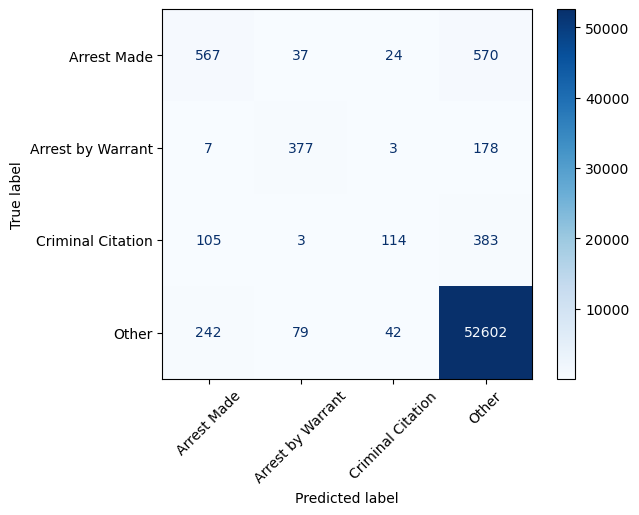

In [121]:
cm = confusion_matrix(y_test, y_pred_nn_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()

### XGBoost

In [124]:
def objective(trial):
    params = {
        'n_estimators': 300,
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }
    
    xgb_clf = XGBClassifier(**params, eval_metric='logloss')
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    try:
        scores = cross_val_score(xgb_clf, X_train_resampled, y_train_resampled, scoring='f1_macro', cv=cv, n_jobs=1)
        return np.mean(scores)
    except Exception as e:
        print(f"An error occurred: {e}")
        return float('-inf')

# Create a study object and specify the direction is 'maximize' for f1_macro score
study = optuna.create_study(direction='maximize')

# Number of trials
n_trials = 20

# Optimize the study
start_time = time.time()
study.optimize(objective, n_trials=n_trials, n_jobs=1, catch=(Exception,))
end_time = time.time()

actual_runtime = end_time - start_time
print(f"Actual runtime: {actual_runtime:.2f} seconds ({actual_runtime/60:.2f} minutes)")

# Print the best parameters and score
print("Best parameters found: ", study.best_params)
print("Best F1 macro score: ", study.best_value)

[I 2024-10-07 22:37:23,739] A new study created in memory with name: no-name-e643216e-cce0-4b26-9c28-d63ee4a1b0e1
[I 2024-10-07 22:37:41,524] Trial 0 finished with value: 0.7355706492682742 and parameters: {'learning_rate': 0.08376958435838196, 'max_depth': 6, 'subsample': 0.7629165199832288, 'colsample_bytree': 0.7397628869578367, 'gamma': 0.0006882254089136715, 'reg_alpha': 0.4228335560532591, 'reg_lambda': 0.005501481329727073}. Best is trial 0 with value: 0.7355706492682742.
[I 2024-10-07 22:37:59,120] Trial 1 finished with value: 0.6895323437658433 and parameters: {'learning_rate': 0.011742913641497226, 'max_depth': 5, 'subsample': 0.9918833175601499, 'colsample_bytree': 0.7483848749219248, 'gamma': 0.03380323115901734, 'reg_alpha': 1.9536548755495387e-05, 'reg_lambda': 4.59598110279651e-08}. Best is trial 0 with value: 0.7355706492682742.
[I 2024-10-07 22:38:13,057] Trial 2 finished with value: 0.7292644732499092 and parameters: {'learning_rate': 0.09608729540379127, 'max_depth':

Actual runtime: 919.71 seconds (15.33 minutes)
Best parameters found:  {'learning_rate': 0.06980273132923291, 'max_depth': 11, 'subsample': 0.6326300380567452, 'colsample_bytree': 0.7609484832093283, 'gamma': 0.7967051121356986, 'reg_alpha': 8.436833013102928e-06, 'reg_lambda': 0.24246652276502442}
Best F1 macro score:  0.7381254674787442


In [125]:
# train the final model with the best parameters:
best_params = study.best_params
xgb_1_model = XGBClassifier(**best_params, eval_metric='logloss')
xgb_1_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7609484832093283, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.7967051121356986, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06980273132923291,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [126]:
y_pred_best_xgb = xgb_1_model.predict(X_test)

xgb_1_accuracy = accuracy_score(y_test, y_pred_best_xgb)
xgb_1_recall = recall_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_prec = precision_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_f1 = f1_score(y_test, y_pred_best_xgb, average='macro')

# Evaluate the best model
print("Best XGBoost Classification Report:")
print(classification_report(y_test, y_pred_best_xgb, zero_division=0, target_names=label_names))

Best XGBoost Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.65      0.36      0.47      1198
Arrest by Warrant       0.76      0.64      0.69       565
Criminal Citation       0.59      0.19      0.28       605
            Other       0.98      0.99      0.99     52965

         accuracy                           0.97     55333
        macro avg       0.74      0.55      0.61     55333
     weighted avg       0.96      0.97      0.96     55333



In [127]:
best_xg = xgb_1_model
joblib.dump(best_xg, f"models/{year}/xgb_model.pkl") 

['models/2016/xgb_model.pkl']

In [128]:
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

## Ensemble

In [130]:
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

In [131]:
print(f'LR F1: {f1_score(y_test, best_lr.predict(X_test), average='macro')}')
print(f'RF F1: {f1_score(y_test, best_rf.predict(X_test), average='macro')}')
print(f'XGB F1: {f1_score(y_test, best_xg.predict(X_test), average='macro')}')

LR F1: 0.6060407720910146
RF F1: 0.6037352041298126
XGB F1: 0.6072330804149094


In [132]:
best_lr

LogisticRegression(C=10, max_iter=1000, random_state=42)

In [133]:
best_rf

RandomForestClassifier(n_estimators=50)

In [134]:
best_xg

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7609484832093283, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.7967051121356986, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06980273132923291,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [135]:
estimators = [
    ('lr', best_lr),
    ('rf', best_rf),
    ('xg', best_xg)
]

base_estimators_fitted = [best_lr, best_rf, best_xg]

In [136]:
X_train_float = X_train.astype('float64')

In [137]:
stacking_clf_2 = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier(), n_jobs=2)
stacking_clf_2.fit(X_train_float, y_train)

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=10, max_iter=1000,
                                                   random_state=42)),
                               ('rf', RandomForestClassifier(n_estimators=50)),
                               ('xg',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.7609484832093283,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              e...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   n_jobs=2)

In [138]:
joblib.dump(stacking_clf_2, f"models/{year}/stacking_2.pkl") 

['models/2016/stacking_2.pkl']

In [139]:
stacking_clf_2 = joblib.load(f"models/{year}/stacking_2.pkl")

In [140]:
y_pred_stacking_2 = stacking_clf_2.predict(X_test)
stack_2_accuracy = accuracy_score(y_test, y_pred_stacking_2)
stack_2_recall = recall_score(y_test, y_pred_stacking_2, average='macro')
stack_2_prec = precision_score(y_test, y_pred_stacking_2, average='macro')
stack_2_f1 = f1_score(y_test, y_pred_stacking_2, average='macro')
print(f"Stacking Classifier F1 Score: {stack_2_f1}")

Stacking Classifier F1 Score: 0.62568681414242


In [141]:
print("Ensemble Classification Report:")
print(classification_report(y_test, y_pred_stacking_2, zero_division=0, target_names=label_names))

Ensemble Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.61      0.44      0.51      1198
Arrest by Warrant       0.75      0.66      0.70       565
Criminal Citation       0.50      0.21      0.30       605
            Other       0.98      0.99      0.99     52965

         accuracy                           0.97     55333
        macro avg       0.71      0.58      0.63     55333
     weighted avg       0.96      0.97      0.97     55333



## Results

In [143]:
from sklearn.metrics import f1_score

baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
lr_accuracy = accuracy_score(y_test, y_pred_best_lr)
rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
mlp_accuracy = accuracy_score(y_test, y_pred_nn_classes)

baseline_recall = recall_score(y_test, y_pred_baseline, average='macro')
lr_recall = recall_score(y_test, y_pred_best_lr, average='macro')
rf_recall = recall_score(y_test, y_pred_best_rf, average='macro')
mlp_recall = recall_score(y_test, y_pred_nn_classes, average='macro')

baseline_prec = precision_score(y_test, y_pred_baseline, average='macro', zero_division=0)
lr_prec = precision_score(y_test, y_pred_best_lr, average='macro', zero_division=0)
rf_prec = precision_score(y_test, y_pred_best_rf, average='macro', zero_division=0)
mlp_prec = precision_score(y_test, y_pred_nn_classes, average='macro', zero_division=0)

baseline_f1 = f1_score(y_test, y_pred_baseline, average='macro')
lr_f1 = f1_score(y_test, y_pred_best_lr, average='macro')
rf_f1 = f1_score(y_test, y_pred_best_rf, average='macro')
mlp_f1 = f1_score(y_test, y_pred_nn_classes, average='macro')

results = pd.DataFrame({
    'Model': ['Baseline', 'Logistic Regression', 'Random Forest', 'MLP', 'XGB', 'Ensemble'],
    'Accuracy': [baseline_accuracy, lr_accuracy, rf_accuracy, mlp_accuracy, xgb_1_accuracy, stack_2_accuracy],
    'Recall': [baseline_recall, lr_recall, rf_recall, mlp_recall, xgb_1_recall, stack_2_recall],
    'Precision': [baseline_prec, lr_prec, rf_prec, mlp_prec, xgb_1_prec, stack_2_prec],
    'F1-score': [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_2_f1]
})
results.set_index('Model')

,Accuracy,Recall,Precision,F1-score
Model,,,,
Baseline,0.957205,0.250000,0.239301,0.244534
Logistic Regression,0.968319,0.554652,0.731408,0.606041
Random Forest,0.965861,0.558577,0.676933,0.603735
MLP,0.969765,0.580530,0.744405,0.630287
XGB,0.968699,0.546587,0.743035,0.607233
Ensemble,0.968988,0.576720,0.712697,0.625687


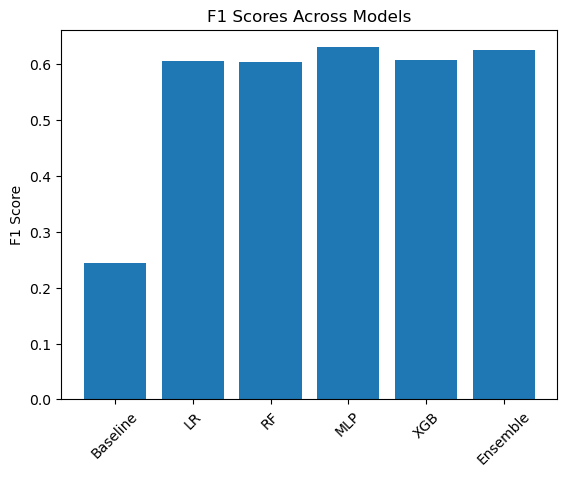

In [144]:
model_names = ['Baseline', 'LR', 'RF', 'MLP', 'XGB', 'Ensemble']
f1_scores = [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_2_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title('F1 Scores Across Models')
plt.show()

## Comparison with the All-Year Models

In [146]:
all_yr_lr = joblib.load("models/all_yr_best_logistic_regression.pkl")
all_yr_rf = joblib.load("models/all_yr_best_random_forest.pkl")
all_yr_xg = joblib.load("models/all_yr_xgb_model.pkl")
all_yr_stack = joblib.load("models/all_yr_stacking_2.pkl")

In [147]:
all_yr_lr_f1 = f1_score(y_test, all_yr_lr.predict(X_test), average='macro')
all_yr_rf_f1 = f1_score(y_test, all_yr_rf.predict(X_test), average='macro')
all_yr_xg_f1 = f1_score(y_test, all_yr_xg.predict(X_test), average='macro')
all_yr_stack_f1 = f1_score(y_test, all_yr_stack.predict(X_test), average='macro')

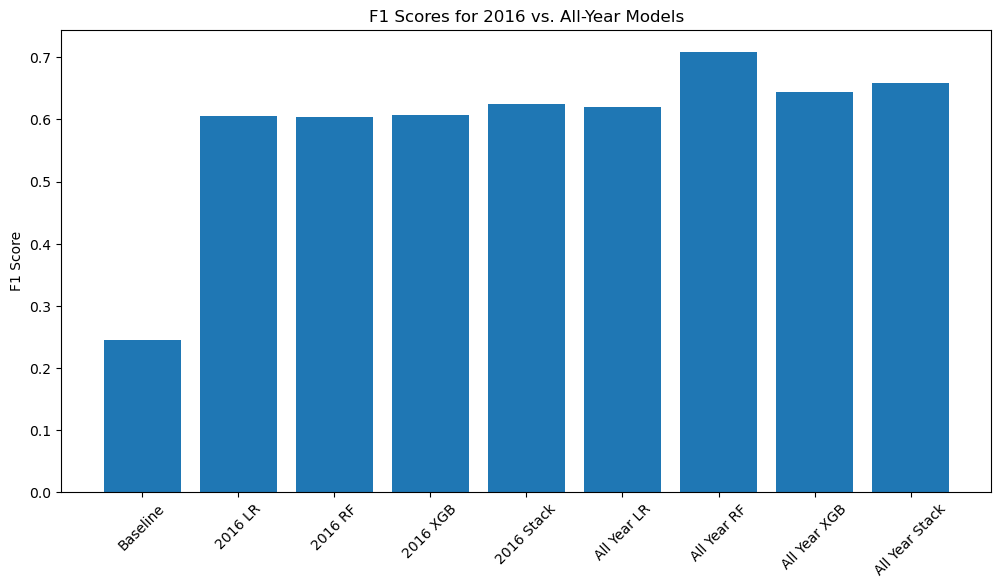

In [148]:
plt.figure(figsize=(12, 6))  # Adjust the width (12) and height (6) as needed

model_names = ['Baseline', f'{year} LR', f'{year} RF', f'{year} XGB', f'{year} Stack', 'All Year LR', 'All Year RF', 'All Year XGB', 'All Year Stack']
f1_scores = [baseline_f1, lr_f1, rf_f1, xgb_1_f1, stack_2_f1, all_yr_lr_f1, all_yr_rf_f1, all_yr_xg_f1, all_yr_stack_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title(f'F1 Scores for {year} vs. All-Year Models')
plt.show()

## 2016 vs. Non-2016 Models

In [150]:
other_years = [y for y in range(2013, 2025) if str(y) != year]
other_years

[2013, 2014, 2015, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

In [151]:
other_years_df = model_utils.load_data(other_years)
model_utils.transform_offense_date(other_years_df)
dispo_mapping = model_utils.calc_dispo_subset(other_years_df)
all_police_df.shape

(309252, 24)

In [152]:
other_years_clean = model_utils.clean_and_transform_data(other_years_df)
other_years_clean.shape

Police Calls Dataset: 3277605 rows before cleaning, 2923772 rows after cleaning.


(2923772, 15)

In [153]:
X_train_oy, X_test_oy, y_train_oy, y_test_oy, _, _, X_train_resampled_oy, y_train_resampled_oy, _ = \
    model_utils.split_data(other_years_clean, dispo_mapping, encoder)

classes = ['A' 'B' 'C' 'Other']
(2339017, 14)
(584755, 14)
['Arrest Made', 'Arrest by Warrant', 'Criminal Citation', 'Other']


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Counter({3: 2244939, 0: 47803, 2: 26262, 1: 20013})
Counter({3: 94078, 0: 47803, 2: 26262, 1: 20013})


In [154]:
rf_model_oy = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs = -1)
rf_model_oy.fit(X_train_oy, y_train_oy)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [155]:
y_pred_rf_oy = rf_model_oy.predict(X_test_oy)

print(f"Random Forest Other Years Classification Report for Non-{year} Data:")
print(classification_report(y_test_oy, y_pred_rf_oy, zero_division=0, target_names=label_names))

Random Forest Other Years Classification Report for Non-2016 Data:
                   precision    recall  f1-score   support

      Arrest Made       0.54      0.35      0.43     11951
Arrest by Warrant       0.68      0.52      0.59      5003
Criminal Citation       0.46      0.22      0.30      6566
            Other       0.98      0.99      0.98    561235

         accuracy                           0.97    584755
        macro avg       0.67      0.52      0.58    584755
     weighted avg       0.96      0.97      0.96    584755



In [156]:
y_pred_rf_oy_2016 = rf_model_oy.predict(X_test)

print(f"Random Forest Other Years Classification Report for {year} Data:")
print(classification_report(y_test, y_pred_rf_oy_2016, zero_division=0, target_names=label_names))

Random Forest Other Years Classification Report for 2016 Data:
                   precision    recall  f1-score   support

      Arrest Made       0.59      0.44      0.50      1198
Arrest by Warrant       0.76      0.64      0.70       565
Criminal Citation       0.54      0.21      0.30       605
            Other       0.98      0.99      0.99     52965

         accuracy                           0.97     55333
        macro avg       0.71      0.57      0.62     55333
     weighted avg       0.96      0.97      0.96     55333



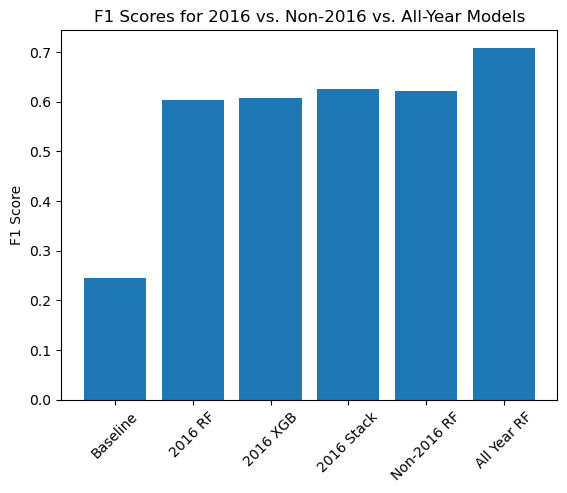

In [157]:
model_names = ['Baseline', f'{year} RF', f'{year} XGB', f'{year} Stack', f'Non-{year} RF', 'All Year RF']
f1_scores = [baseline_f1, rf_f1, xgb_1_f1, stack_2_f1, f1_score(y_test, y_pred_rf_oy_2016, average='macro'), all_yr_rf_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title(f'F1 Scores for {year} vs. Non-{year} vs. All-Year Models')
plt.show()